In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
%matplotlib inline

import datetime
import math
import os


from IPython.display import display

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tools.eval_measures import rmse

from sklearn.linear_model import LinearRegression, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

from sklearn.model_selection import KFold, cross_val_score, train_test_split

import warnings
warnings.filterwarnings("ignore")

## Load and View Data

In [18]:
date = "txn_date"

def load_data(csv_path:str, usecols:list=None) -> pd.DataFrame:
    data = pd.read_csv(csv_path)
    data.columns = data.columns.str.lower()
    
    if usecols:
        usecols += [date]
        data = data[set(usecols)]
    
    return data

def resample_data_freq(data:pd.DataFrame, freq:str, target_col) -> pd.DataFrame:
    data = data.copy()
    
    data[date] = pd.to_datetime(data[date])
    data.set_index([date], inplace=True)
    
    data = data.resample(rule=freq).sum()
    data = data[data[target_col] != 0.0]
    
    data.reset_index(inplace=True)
    return data
    

target_col = "amount"
freq = "D"
csv_path = "supervised_model.csv"
lags = 13
test_ratio = 12


sales_data = load_data(csv_path=csv_path, usecols=[target_col])
freq_data = resample_data_freq(data=sales_data, target_col=target_col, freq=freq)

In [19]:
sales_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 280 entries, 0 to 279
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   txn_date  280 non-null    object 
 1   amount    280 non-null    float64
dtypes: float64(1), object(1)
memory usage: 4.5+ KB


In [20]:
display(sales_data.head())
freq_data.head()

,txn_date,amount
0,2020-07-27,3433.5
1,2020-07-28,1990.0
2,2020-07-29,1897.5
3,2020-07-30,3244.5
4,2020-07-31,3225.0


,txn_date,amount
0,2020-07-27,3433.5
1,2020-07-28,1990.0
2,2020-07-29,1897.5
3,2020-07-30,3244.5
4,2020-07-31,3225.0


# EDA

In [21]:
# Duration of dataset
def sales_duration(data):
    data[date] = pd.to_datetime(data[date])
    number_of_days = data[date].max() - data[date].min()
    number_of_years = round(number_of_days.days / 365)
    number_of_months = round(number_of_days.days / 30)
    numver_of_weeks = round(number_of_days.days / 7)
    
    print(number_of_days.days, 'days')
    print(numver_of_weeks, 'weeks')
    print(number_of_months, 'months')
    print(number_of_years, 'years')
    
sales_duration(data=sales_data)

279 days
40 weeks
9 months
1 years


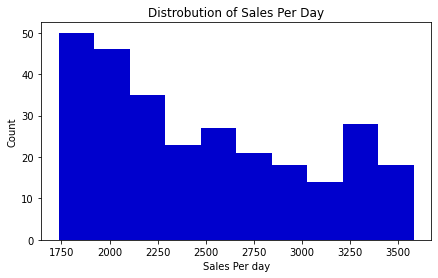

In [22]:
def sales_per_day(data, target_col, period):
    fig, ax = plt.subplots(figsize=(7,4))
    plt.hist(data[target_col], color='mediumblue')
    
    ax.set(xlabel = f"Sales Per {period}", ylabel = "Count", title = f"Distrobution of Sales Per {period.title()}")
    
sales_per_day(data=sales_data, target_col=target_col, period="day")

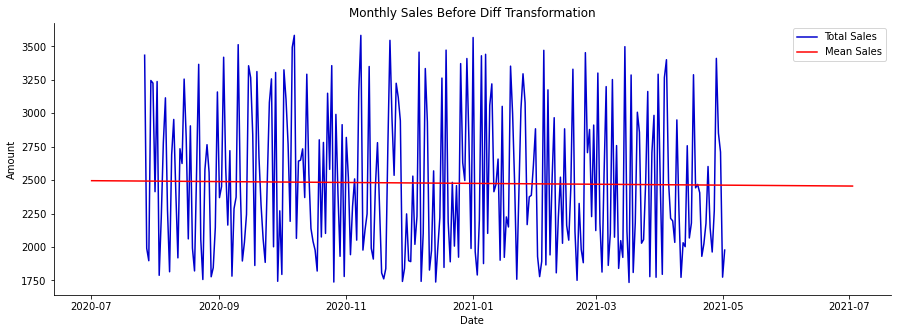

In [26]:
def time_plot(data, x_col, y_col, title):
    fig, ax = plt.subplots(figsize=(15,5))
    sns.lineplot(x_col, y_col, data=data, ax=ax, color='mediumblue', label='Total Sales')
    
    if y_col.replace("_diff", "") == "total":
        second = data.groupby(data[date].dt.week)[y_col].mean().reset_index()
        second[date] = pd.date_range(start=data[date].min(), end=data[date].max(), periods=13)
        sns.lineplot((second[date] + datetime.timedelta(0*365/12)), y_col, data=second, ax=ax, color='red', label='Mean Sales')   
    else:
        second = data.groupby(data[date].dt.year)[y_col].mean().reset_index()
        second[date] = pd.to_datetime(second[date], format='%Y')
        sns.lineplot((second[date] + datetime.timedelta(6*365/12)), y_col, data=second, ax=ax, color='red', label='Mean Sales')   
    
    
    
    ax.set(xlabel = "Date", ylabel = f"{y_col.title()}", title = title)
    sns.despine()
    
time_plot(freq_data, date, target_col, 'Monthly Sales Before Diff Transformation')

## Stationary Test

In [27]:
# check stationary
from statsmodels.tsa.stattools import adfuller

df_test = adfuller(freq_data[target_col], autolag="AIC")

print("1. ADF : ", df_test[0])
print("2. P-value : ", df_test[1])
print("3. Num of lags : ", df_test[2])
print("4. Num of obs used for ADF reg and critical values calc : ", df_test[3])
print("5. Critical value : ", df_test[4])

for key, val in df_test[4].items():
    print("\t", key, " : ", val)

1. ADF :  -8.144094162049974
2. P-value :  1.0097661305084603e-12
3. Num of lags :  7
4. Num of obs used for ADF reg and critical values calc :  272
5. Critical value :  {'1%': -3.4546223782586534, '5%': -2.8722253212300277, '10%': -2.5724638500216264}
	 1%  :  -3.4546223782586534
	 5%  :  -2.8722253212300277
	 10%  :  -2.5724638500216264


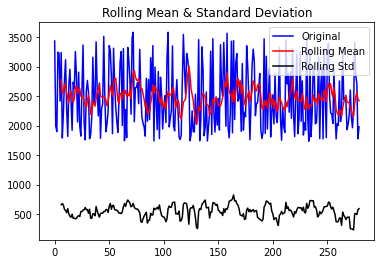

Results of Dickey-Fuller Test:


,0,Critical Value (1%),Critical Value (5%),Critical Value (10%)
Test Statistic,-8.144094e+00,-3.454622,-2.872225,-2.572464
p-value,1.009766e-12,-3.454622,-2.872225,-2.572464
#Lags Used,7.000000e+00,-3.454622,-2.872225,-2.572464
Number of Observations Used,2.720000e+02,-3.454622,-2.872225,-2.572464


In [28]:
def test_stationarity(timeseries, window):
    #Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()
    
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.DataFrame(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
        
    display(dfoutput)
    
test_stationarity(freq_data[target_col], 7)

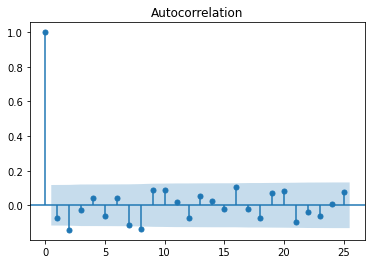

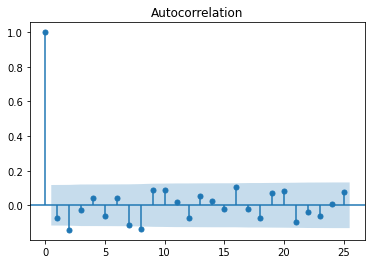

In [29]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

data = freq_data.copy()
data.set_index([date], inplace=True)


plot_acf(data)

In [30]:
display(data.head())
data.shift(1).head()

,amount
txn_date,
2020-07-27,3433.5
2020-07-28,1990.0
2020-07-29,1897.5
2020-07-30,3244.5
2020-07-31,3225.0


,amount
txn_date,
2020-07-27,NaN
2020-07-28,3433.5
2020-07-29,1990.0
2020-07-30,1897.5
2020-07-31,3244.5


In [31]:
data_diff = data.diff(periods=1).dropna()
data_diff.head()

,amount
txn_date,
2020-07-28,-1443.5
2020-07-29,-92.5
2020-07-30,1347.0
2020-07-31,-19.5
2020-08-01,-811.5


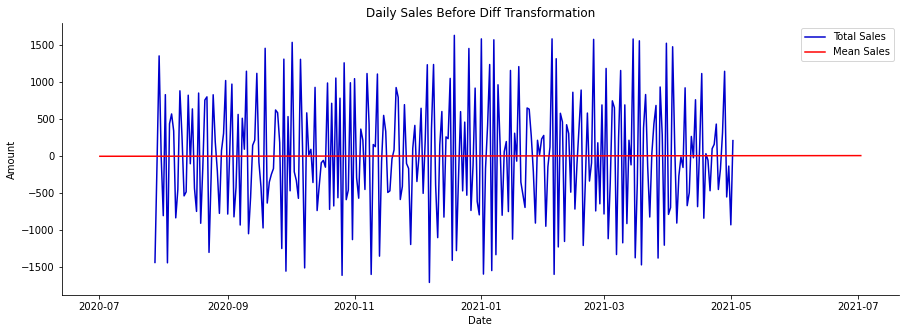

In [33]:
time_plot(data_diff.reset_index(), date, target_col, 'Daily Sales Before Diff Transformation')

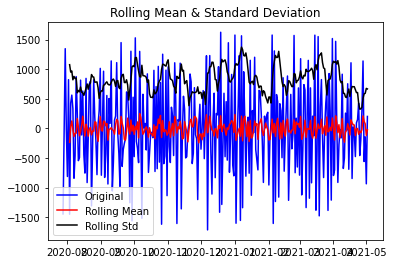

Results of Dickey-Fuller Test:


,0,Critical Value (1%),Critical Value (5%),Critical Value (10%)
Test Statistic,-8.673365e+00,-3.455365,-2.872551,-2.572638
p-value,4.483795e-14,-3.455365,-2.872551,-2.572638
#Lags Used,1.400000e+01,-3.455365,-2.872551,-2.572638
Number of Observations Used,2.640000e+02,-3.455365,-2.872551,-2.572638


In [34]:
test_stationarity(data_diff[target_col], 7)

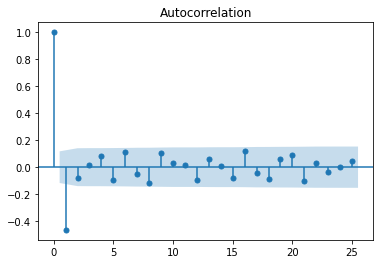

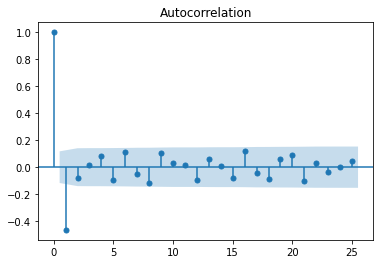

In [35]:
plot_acf(data_diff)

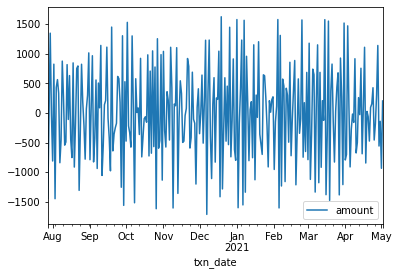

In [36]:
data_diff.plot()
plt.show()

In [38]:
from statsmodels.tsa.ar_model import AR

freq_train = freq_data.set_index([date]).values[:-8]
freq_test = freq_data.set_index([date]).values[-8:]

freq_data.shape, freq_train.shape, freq_test.shape

((280, 2), (272, 1), (8, 1))

# Autoregressive AR

In [39]:
model_ar = AR(freq_train)
model_ar_fit = model_ar.fit()

In [40]:
predictions = model_ar_fit.predict(start=80, end=89)

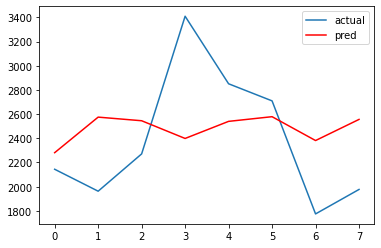

In [42]:
plt.plot(freq_test, label="actual")
plt.plot(predictions[:len(freq_test)], "r", label="pred")
plt.legend()
plt.show()

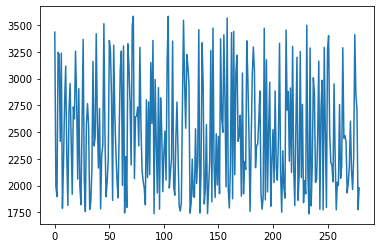

In [43]:
freq_data[target_col].plot()
plt.show()

In [44]:
predictions = predictions[:len(freq_test)].reshape(-1, 1)
pd.DataFrame(np.concatenate([freq_test, predictions], axis=1), columns=["actual", "pred"])

,actual,pred
0,2144.00,2281.165032
1,1962.50,2575.327096
2,2271.00,2545.413872
3,3410.00,2398.831053
4,2851.25,2540.260187
5,2709.75,2578.927819
6,1774.50,2381.573832
7,1977.00,2556.464631


# ARIMA model

In [45]:
from statsmodels.tsa.arima_model import ARIMA

In [46]:
model_arima = ARIMA(freq_train, order=(0, 0, 0))
model_arima_fit = model_arima.fit()
model_arima_fit.aic

4203.771187639904

In [47]:
predictions = model_arima_fit.forecast(steps=len(freq_test))[0]

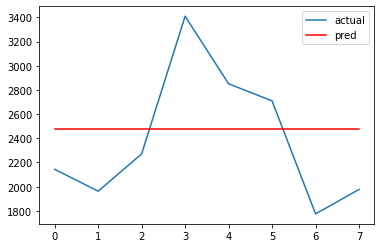

In [48]:
plt.plot(freq_test, label="actual")
plt.plot(predictions[:len(freq_test)], "r", label="pred")
plt.legend()
plt.show()

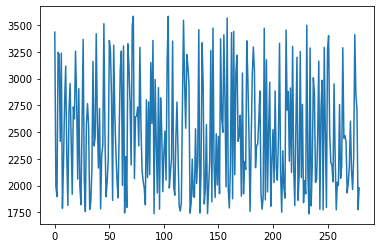

In [49]:
freq_data[target_col].plot()
plt.show()

In [50]:
predictions = predictions[:len(freq_test)].reshape(-1, 1)
pd.DataFrame(np.concatenate([freq_test, predictions], axis=1), columns=["actual", "pred"])

,actual,pred
0,2144.00,2480.875184
1,1962.50,2480.875184
2,2271.00,2480.875184
3,3410.00,2480.875184
4,2851.25,2480.875184
5,2709.75,2480.875184
6,1774.50,2480.875184
7,1977.00,2480.875184


In [ ]:
import itertools

p=d=q = range(0, 15)
pdq = list(itertools.product(p, d, q))
pdqs = []

for param in pdq:
    try:
        model_arima = ARIMA(freq_train, order=param)
        model_arima_fit = model_arima.fit()
        pdqs.append({"pqd": param, "score":model_arima_fit.aic})
    except:
        continue

/home/vegas/.local/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/vegas/.local/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/vegas/.local/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/vegas/.local/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/vegas/.local/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInver

In [ ]:
pdqs